# File setup from Github:

In [7]:
!pip install -q xlrd
!rm -f -r 150-DNN-Final
!git clone https://github.com/jeremyliweishih/150-DNN-Final


Cloning into '150-DNN-Final'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 413 (delta 16), reused 0 (delta 0), pack-reused 386
Receiving objects: 100% (413/413), 10.61 MiB | 23.25 MiB/s, done.
Resolving deltas: 100% (232/232), done.


In [8]:
# Files from the cloned git repository.
!ls 150-DNN-Final/

BBB	 BCNN-BBB.ipynb  DNN_Proposal.pdf      README.md
BBB_old  CNN.ipynb	 dropoutasbayes.ipynb


In [9]:
#need to upload kaggle auth token
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jeremyshih","key":"9c6ce9d2bbd165b6d81441d879ddaa11"}'}

In [0]:
!mkdir ~/.kaggle/

In [0]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [12]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000  

 99% 2.59G/2.62G [00:38<00:00, 56.2MB/s]
100% 2.62G/2.62G [00:38<00:00, 73.6MB/s]


In [13]:
!unzip skin-cancer-mnist-ham10000.zip

Archive:  skin-cancer-mnist-ham10000.zip
  inflating: hmnist_28_28_RGB.csv    
  inflating: HAM10000_metadata.csv   
  inflating: HAM10000_images_part_1.zip  
  inflating: hmnist_28_28_L.csv      
  inflating: hmnist_8_8_L.csv        
  inflating: HAM10000_images_part_2.zip  
  inflating: hmnist_8_8_RGB.csv      


In [0]:
!unzip HAM10000_images_part_1.zip
!unzip HAM10000_images_part_2.zip

# Load images: 
loading code creds: https://www.kaggle.com/sid321axn/step-wise-approach-cnn-model-77-0344-accuracy

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools


In [0]:
base_skin_dir = os.path.join('./', '')

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*.jpg'))}

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

# Creating New Columns for better readability

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [17]:
#load images and fillna
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)
skin_df['cell_type_idx'] = skin_df['cell_type_idx'].apply(lambda x: int(x))
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,./ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,./ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,./ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,./ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,./ISIC_0031633.jpg,Benign keratosis-like lesions,2


In [18]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((32,32))))
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,./ISIC_0027419.jpg,Benign keratosis-like lesions,2,"[[[189, 149, 186], [192, 154, 193], [199, 154,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,./ISIC_0025030.jpg,Benign keratosis-like lesions,2,"[[[23, 15, 26], [60, 42, 68], [107, 81, 116], ..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,./ISIC_0026769.jpg,Benign keratosis-like lesions,2,"[[[186, 134, 147], [198, 146, 159], [196, 142,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,./ISIC_0025661.jpg,Benign keratosis-like lesions,2,"[[[32, 16, 27], [88, 57, 73], [128, 80, 96], [..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,./ISIC_0031633.jpg,Benign keratosis-like lesions,2,"[[[153, 111, 133], [189, 143, 172], [208, 158,..."


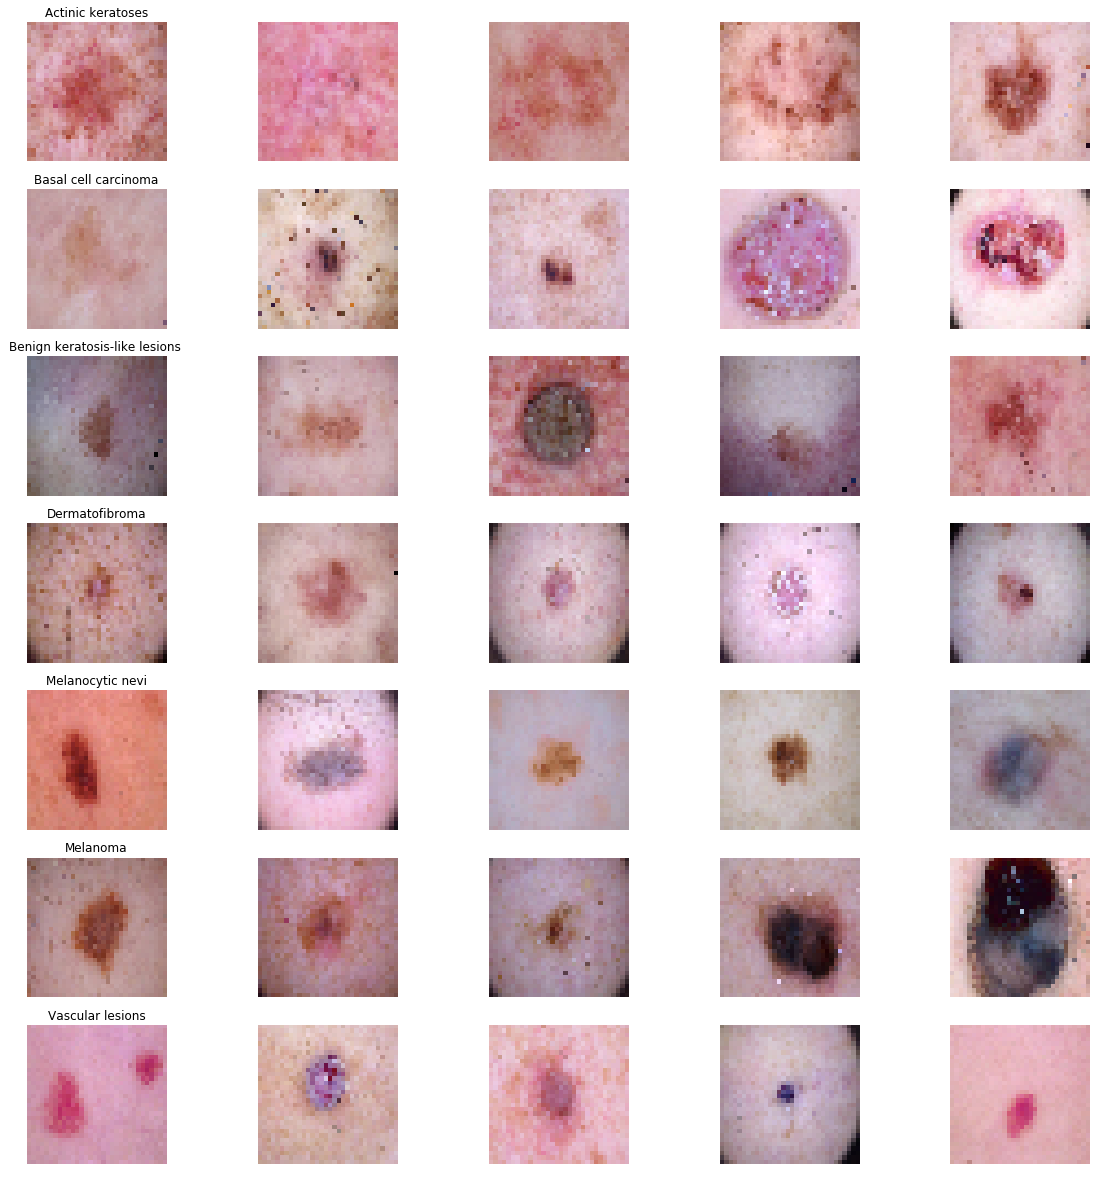

In [19]:
#check samples
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [20]:
!nvidia-smi

Wed May  1 02:26:35 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    16W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Pytorch Custom Dataset:

In [0]:
from torch.utils.data.dataset import Dataset
import torchvision
import torchvision.transforms as transforms

class CustomDatasetFromImages(Dataset):
    def __init__(self, df, transforms=None):
        """
        Args:
            transform: pytorch transforms for transforms and tensor conversion
        """
        # Tensor Transform
#         self.to_tensor = transforms.ToTensor()
        self.transforms = transforms
        # Read the csv file
        self.dataset = df
        # 10th column contains the images
        self.image_arr = np.asarray(self.dataset.iloc[:, 10])
        # 9th column is the labels
        self.label_arr = np.asarray(self.dataset.iloc[:, 9])
        # Calculate len
        self.data_len = len(self.dataset.index)

    def __getitem__(self, index):
        # Open image
        img_as_np = self.image_arr[index]
        img_as_img = Image.fromarray(img_as_np)

#         # Transform image to tensor
#         img_as_tensor = self.to_tensor(img_as_img)
        
        if self.transforms:
                  img_as_tensor = self.transforms(img_as_img)

        # Get label(class) of the image based on the cropped pandas column
        single_image_label = self.label_arr[index]

        return (img_as_tensor, single_image_label)

    def __len__(self):
        return self.data_len

# Setup NN

In [22]:
%load_ext autoreload
%autoreload 2

import torchvision
import torchvision.transforms as transforms
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical


Using TensorFlow backend.


In [23]:
!ls 150-DNN-Final/BBB_old

Bayesian_config.py  Frequentist_config.py  README.md
extraction	    main_Bayes.py	   results
figures		    main_Frequentist.py    utils


In [0]:
import sys
sys.path.append('/content/150-DNN-Final/BBB_old/')

from utils.BBBlayers import GaussianVariationalInference
from utils.BayesianModels.Bayesian3Conv3FC import BBB3Conv3FC
from utils.BayesianModels.BayesianAlexNet import BBBAlexNet
from utils.BayesianModels.BayesianLeNet import BBBLeNet

In [0]:
outputs = 7
inputs = 3
resume = False
n_epochs = 100
lr = 0.001
weight_decay = 0.0005
num_samples = 10
beta_type = "Blundell"
resize=32

use_cuda = torch.cuda.is_available()
torch.cuda.set_device(0)

In [0]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32
# percentage of training set to use as validation
valid_size = 0.2

In [0]:
# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])


In [0]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

train_data, test_data = train_test_split(skin_df, test_size=0.20,random_state=1234)

In [0]:
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

In [30]:
train_data.head()
test_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000628,ISIC_0024567,nv,follow_up,35.0,female,lower extremity,./ISIC_0024567.jpg,Melanocytic nevi,4,"[[[208, 115, 133], [211, 119, 142], [212, 122,..."
1,HAM_0004226,ISIC_0032760,nv,histo,25.0,female,trunk,./ISIC_0032760.jpg,Melanocytic nevi,4,"[[[55, 45, 56], [102, 86, 99], [125, 108, 126]..."
2,HAM_0002015,ISIC_0034035,nv,histo,30.0,female,lower extremity,./ISIC_0034035.jpg,Melanocytic nevi,4,"[[[148, 136, 160], [158, 147, 164], [161, 147,..."
3,HAM_0001651,ISIC_0033251,nv,histo,45.0,male,back,./ISIC_0033251.jpg,Melanocytic nevi,4,"[[[117, 103, 120], [129, 115, 130], [131, 117,..."
4,HAM_0003206,ISIC_0025199,bkl,histo,60.0,female,lower extremity,./ISIC_0025199.jpg,Benign keratosis-like lesions,2,"[[[190, 172, 184], [187, 166, 175], [188, 168,..."


In [0]:
train_set = CustomDatasetFromImages(train_data, transforms=transform)
test_set = CustomDatasetFromImages(test_data, transforms=transform)

In [0]:
# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, 
    num_workers=num_workers)

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

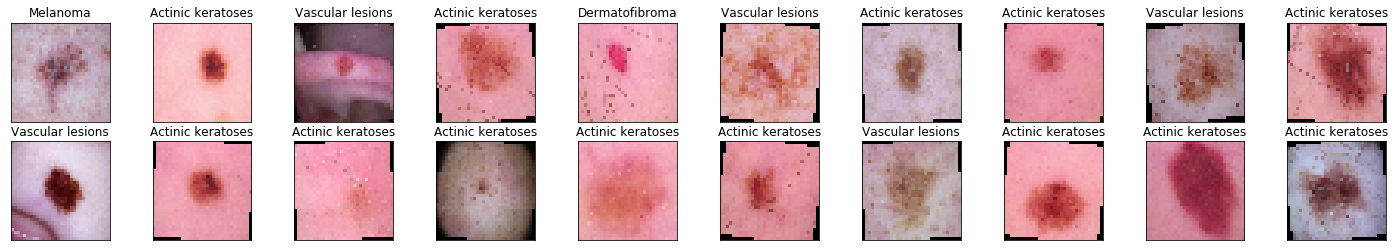

In [55]:
classes = ('Melanocytic nevi', 'Melanoma', 'Benign keratosis-like lesions ', 'Basal cell carcinoma',
            'Actinic keratoses', 'Vascular lesions', 'Dermatofibroma')

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [0]:
net_type = '3conv3fc'
dataset = 'HAM10000'
net = BBB3Conv3FC(outputs,inputs)

In [0]:
use_cuda = torch.cuda.is_available()

if use_cuda:
  net.cuda()

In [0]:
vi = GaussianVariationalInference(torch.nn.CrossEntropyLoss())
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

In [31]:
ckpt_name = f'model_{net_type}_{dataset}_bayesian.pt'
ckpt_name

'model_3conv3fc_HAM10000_bayesian.pt'

In [0]:
torch.cuda.empty_cache()

In [33]:
import math

%time

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    m = math.ceil(len(train_data) / batch_size)
    
    ###################
    # train the model #
    ###################
    net.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        data = data.view(-1, inputs, resize, resize).repeat(num_samples, 1, 1, 1)
        target = target.repeat(num_samples)
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        if beta_type is "Blundell":
            beta = 2 ** (m - (batch_idx + 1)) / (2 ** m - 1)
        elif beta_type is "Soenderby":
            beta = min(epoch / (num_epochs // 4), 1)
        elif beta_type is "Standard":
            beta = 1 / m
        else:
            beta = 0
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output,kl = net.probforward(data)
        # calculate the batch loss
        loss = vi(output, target, kl, beta)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += (loss.item()*data.size(0)) / num_samples
        
    ######################    
    # validate the model #
    ######################
    net.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        data = data.view(-1, inputs, resize, resize).repeat(num_samples, 1, 1, 1)
        target = target.repeat(num_samples)
        # move tensors to GPU if CUDA is available
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output,kl = net.probforward(data)
        # calculate the batch loss
        loss = vi(output, target, kl, beta)
        # update average validation loss 
        valid_loss += (loss.item()*data.size(0)) / num_samples
        
    # calculate average losses
    
    train_loss = train_loss/(len(train_loader.dataset) * (1-valid_size))
    valid_loss = valid_loss/(len(valid_loader.dataset) * valid_size)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(net.state_dict(), ckpt_name)
        valid_loss_min = valid_loss

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs
Epoch: 1 	Training Loss: 7609.089222 	Validation Loss: 3.376406
Validation loss decreased (inf --> 3.376406).  Saving model ...
Epoch: 2 	Training Loss: 7238.089660 	Validation Loss: 1.557689
Validation loss decreased (3.376406 --> 1.557689).  Saving model ...
Epoch: 3 	Training Loss: 6704.936591 	Validation Loss: 1.370505
Validation loss decreased (1.557689 --> 1.370505).  Saving model ...
Epoch: 4 	Training Loss: 6169.412372 	Validation Loss: 1.313233
Validation loss decreased (1.370505 --> 1.313233).  Saving model ...
Epoch: 5 	Training Loss: 5673.590835 	Validation Loss: 1.278165
Validation loss decreased (1.313233 --> 1.278165).  Saving model ...
Epoch: 6 	Training Loss: 5223.541604 	Validation Loss: 1.276605
Validation loss decreased (1.278165 --> 1.276605).  Saving model ...
Epoch: 7 	Training Loss: 4816.702167 	Validation Loss: 1.268185
Validation loss decreased (1.276605 --> 1.268185).  Saving model ...
Epoch: 8 	

In [0]:
net.load_state_dict(torch.load(ckpt_name))

In [0]:
def calc_uncertainity_softmax(output):
    prediction = F.softmax(output, dim = 1)
    results = torch.max(prediction, 1 )
    p_hat = np.array(results[0].detach().cpu())
    epistemic = np.mean(p_hat ** 2, axis=0) - np.mean(p_hat, axis=0) ** 2
    epistemic += epistemic 
    #print (epistemic)
    aleatoric = np.mean(p_hat * (1-p_hat), axis = 0)
    aleatoric += aleatoric
    #print (aleatoric)
    return epistemic, aleatoric

In [0]:
def calc_uncertainty_normalized(output):
    prediction = F.relu(output)
    prediction = normalization_function(prediction)
    results = torch.max(prediction, 1 )
    p_hat = np.array(results[0].detach().cpu())
    epistemic = np.mean(p_hat ** 2, axis=0) - np.mean(p_hat, axis=0) ** 2
    epistemic += epistemic 
    #print (epistemic)
    aleatoric = np.mean(p_hat * (1-p_hat), axis = 0)
    aleatoric += aleatoric
    #print (aleatoric)
    return epistemic, aleatoric
    

In [0]:
def normalization_function(x):
    return (x) / torch.sum(x, dim=0)

In [0]:
# files.download(ckpt_name)

In [37]:
# skip training
# files.upload()

Saving model_3conv3fc_HAM10000_bayesian.pt to model_3conv3fc_HAM10000_bayesian.pt


In [0]:
ckpt_name = f'model_{net_type}_{dataset}_bayesian.pt'

net = BBB3Conv3FC(outputs,inputs)
net.load_state_dict(torch.load(ckpt_name))
use_cuda = True
if use_cuda:
  net.cuda()

In [121]:
%%time

# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

net.eval()
m = math.ceil(len(test_data) / batch_size)
total_e = 0.0
total_a = 0.0
# iterate over test data
k = 1
for batch_idx, (data, target) in enumerate(test_loader):
    k += 1
    data = data.view(-1, inputs, resize, resize).repeat(num_samples, 1, 1, 1)
    target = target.repeat(num_samples)
    # move tensors to GPU if CUDA is available
    if use_cuda:
        data, target = data.cuda(), target.cuda()
    
    if beta_type is "Blundell":
        beta = 2 ** (m - (batch_idx + 1)) / (2 ** m - 1)
    elif cf.beta_type is "Soenderby":
        beta = min(epoch / (cf.num_epochs // 4), 1)
    elif cf.beta_type is "Standard":
        beta = 1 / m
    else:
        beta = 0
    # forward pass: compute predicted outputs by passing inputs to the model
    output, kl = net.probforward(data)
    # calculate the batch loss
    loss = vi(output, target, kl, beta)
    # update test loss 
    test_loss += loss.item()*data.size(0) / num_samples
    #test_loss += loss.item()
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1) 
    
    epistemic , aleatoric = calc_uncertainity_softmax(output)
    
    total_e += epistemic
    total_a += aleatoric 
    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not use_cuda else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        if i >= target.data.shape[0]: # batch_size could be greater than left number of images
            break
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1


average_e = total_e / k
average_a = total_a / k

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))
#epistemic = epistemic/len(test_loader.dataset)
print('Epistemic Uncertainty: {:.6f}\n'.format(average_e))
#aleatoric = aleatoric/len(test_loader.dataset)
print('Aleatoric Uncertainty: {:.6f}\n'.format(average_a))
print('Total Uncertainty: {:.6f}\n'.format(average_e + average_a))

for i in range(7):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 707.474142

Epistemic Uncertainty: 0.104946

Aleatoric Uncertainty: 0.285940

Total Uncertainty: 0.390886

Test Accuracy of Melanocytic nevi: 35% (21/60)
Test Accuracy of Melanoma: 49% (48/97)
Test Accuracy of Benign keratosis-like lesions : 37% (84/226)
Test Accuracy of Basal cell carcinoma:  3% ( 1/27)
Test Accuracy of Actinic keratoses: 90% (1207/1329)
Test Accuracy of Vascular lesions: 41% (104/248)
Test Accuracy of Dermatofibroma: 58% (17/29)

Test Accuracy (Overall): 73% (1482/2016)
CPU times: user 11.9 s, sys: 158 ms, total: 12.1 s
Wall time: 12.1 s


In [0]:
def calc_uncertainty(outputs):
    batch_vars = np.array(outputs).var(axis=0)
    batch_vars = batch_vars.mean(1)
    return batch_vars

In [131]:
np.set_printoptions()
## calculate variances only
%time


net.eval()
T = 100
total_vars = []

for batch_idx, (data, target) in enumerate(test_loader):
    # move tensors to GPU if CUDA is available
    if use_cuda:
        data, target = data.cuda(), target.cuda()
    
    if beta_type is "Blundell":
        beta = 2 ** (m - (batch_idx + 1)) / (2 ** m - 1)
    elif cf.beta_type is "Soenderby":
        beta = min(epoch / (cf.num_epochs // 4), 1)
    elif cf.beta_type is "Standard":
        beta = 1 / m
    else:
        beta = 0

    outputs = []
    for j in range(T):
      output, kl = net.probforward(data)
      outputs.append(output.detach().cpu().numpy())
      
    batch_vars = calc_uncertainty(outputs)
    total_vars = np.append(total_vars, batch_vars)

avg_var = np.array(total_vars).mean()

print(len(total_vars))
print('Total Average Uncertainty: {:.6f}\n'.format(avg_var))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.68 µs
2003
Total Average Uncertainty: 0.588014



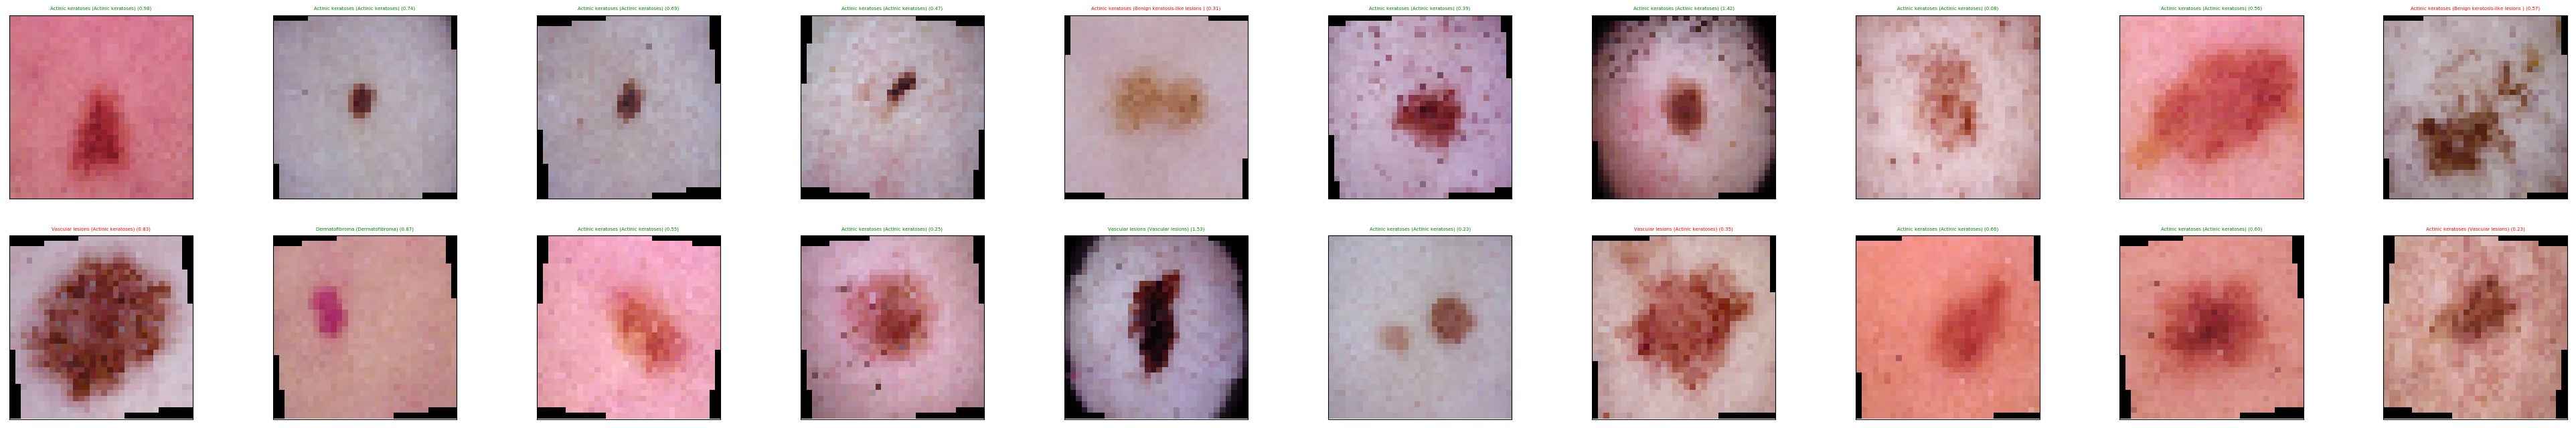

In [198]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if use_cuda:
    images = images.cuda()

# get sample outputs
outputs = []
for j in range(500):
  output, kl = net.probforward(images)
  outputs.append(output.detach().cpu().numpy())

sample_vars = calc_uncertainty(outputs)

sample_vars = ["{:.2f}".format(x) for x in sample_vars]


output = np.array(outputs).mean(0)
output = torch.tensor(output).cuda()

# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())


# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(50, 8))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    image = images[idx].cpu()
    imshow(image)
    ax.set_title("{} ({}) ({})".format(classes[preds[idx]], classes[labels[idx]], sample_vars[idx]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"),
                fontsize=5)

In [0]:
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

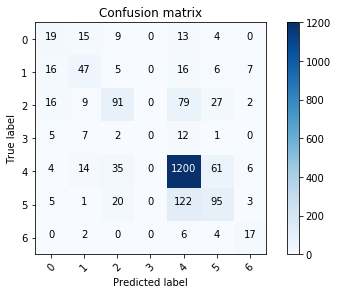

In [153]:
Y_pred = np.array([])
Y_true = np.array([])

for batch_idx, (data, target) in enumerate(test_loader):
    # move tensors to GPU if CUDA is available
    if use_cuda:
        data, target = data.cuda(), target.cuda()
    
    if beta_type is "Blundell":
        beta = 2 ** (m - (batch_idx + 1)) / (2 ** m - 1)
    elif cf.beta_type is "Soenderby":
        beta = min(epoch / (cf.num_epochs // 4), 1)
    elif cf.beta_type is "Standard":
        beta = 1 / m
    else:
        beta = 0
    # forward pass: compute predicted outputs by passing inputs to the model
    output, kl = net.probforward(data)
    # calculate the batch loss
    loss = vi(output, target, kl, beta)
    #test_loss += loss.item()
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1) 
    
    Y_pred = np.append(Y_pred, pred.cpu().numpy())
    Y_true = np.append(Y_true, (target.data.view_as(pred).cpu().numpy()))


# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

In [0]:
FP = confusion_mtx.sum(axis=0) - np.diag(confusion_mtx)  
FN = confusion_mtx.sum(axis=1) - np.diag(confusion_mtx)
TP = np.diag(confusion_mtx)
TN = confusion_mtx.sum() - (FP + FN + TP)

In [171]:
print('True Positives: ', TP)
print('True Negatives: ', TN)
print('False Positives: ', FP)
print('False Negatives: ', FN)


FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

True Positives:  [  19.   47.   91.    0. 1200.   95.   17.]
True Negatives:  [1897. 1858. 1708. 1976.  435. 1654. 1956.]
False Positives:  [ 46.  48.  71.   0. 248. 103.  18.]
False Negatives:  [ 41.  50. 133.  27. 120. 151.  12.]


In [173]:
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)

print(FPR)
print(FNR)

[0.02367473 0.02518363 0.03991006 0.         0.36310395 0.05862265
 0.00911854]
[0.68333333 0.51546392 0.59375    1.         0.09090909 0.61382114
 0.4137931 ]
